In [1]:
using DataFrames, PyPlot, ScikitLearn, LowRankModels, Convex, ECOS
include("proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [7]:
rawBronxData = readtable("2015Bronx.txt", separator = '\t')

,Health_Service_Area,Hospital_County,Operating_Certificate_Number,Facility_ID,Facility_Name,Age_Group,Zip_Code_3_digits,Gender,Race,Ethnicity,Length_of_Stay,Type_of_Admission,Patient_Disposition,Discharge_Year,CCS_Diagnosis_Code,CCS_Diagnosis_Description,CCS_Procedure_Code,CCS_Procedure_Description,APR_DRG_Code,APR_DRG_Description,APR_MDC_Code,APR_MDC_Description,APR_Severity_of_Illness_Code,APR_Severity_of_Illness_Description,APR_Risk_of_Mortality,APR_Medical_Surgical_Description,Payment_Typology_1,Payment_Typology_2,Payment_Typology_3,Attending_Provider_License_Number,Operating_Provider_License_Number,Other_Provider_License_Number,Birth_Weight,Abortion_Edit_Indicator,Emergency_Department_Indicator,Total_Charges,Total_Costs
1,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,M,Black/African American,Not Span/Hispanic,120 +,Emergency,Hospice - Home,2015,657,Mood disorders,177,COMP AXIAL TOMOGR (CT),751,Major depressive disorders & other/unspecified psychoses,19,Mental Diseases and Disorders,3,Major,Moderate,Medical,Medicare,Medicaid,NA,90274929,90274929,209186,0,N,Y,481451.53,470591.98
2,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,70 or Older,104,M,Other Race,Unknown,120 +,Emergency,Home or Self Care,2015,657,Mood disorders,218,PSYCHO/PSYCHI EVAL/THER,754,Depression except major depressive disorder,19,Mental Diseases and Disorders,2,Moderate,Moderate,Medical,Medicaid,NA,NA,251388,251388,NA,0,N,Y,263635.92,257779.49
3,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,18 to 29,OOS,F,Black/African American,Not Span/Hispanic,120 +,Emergency,Home or Self Care,2015,659,Schizophrenia and other psychotic disorders,193,DX ULTRASOUND HEART,750,Schizophrenia,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,NA,NA,251799,251799,NA,0,N,Y,190454.96,189409.1
4,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,0 to 17,104,F,Black/African American,Not Span/Hispanic,99,Emergency,Home or Self Care,2015,657,Mood disorders,218,PSYCHO/PSYCHI EVAL/THER,753,Bipolar disorders,19,Mental Diseases and Disorders,3,Major,Minor,Medical,Medicaid,NA,NA,160912,160912,NA,0,N,Y,131572.31,129374.03
5,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,0 to 17,104,M,Black/African American,Not Span/Hispanic,120 +,Emergency,Home or Self Care,2015,652,"Attention-deficit, conduct, and disruptive behavior disorders",218,PSYCHO/PSYCHI EVAL/THER,758,Behavioral disorders,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,NA,NA,225942,225942,NA,0,N,Y,206076.57,202362.15
6,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,0 to 17,104,F,Black/African American,Not Span/Hispanic,80,Emergency,Home or Self Care,2015,652,"Attention-deficit, conduct, and disruptive behavior disorders",218,PSYCHO/PSYCHI EVAL/THER,758,Behavioral disorders,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,NA,NA,160912,160912,NA,0,N,Y,107137.84,105280.01
7,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,0 to 17,104,M,Other Race,Spanish/Hispanic,107,Emergency,Psychiatric Hospital or Unit of Hosp,2015,659,Schizophrenia and other psychotic disorders,218,PSYCHO/PSYCHI EVAL/THER,750,Schizophrenia,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,Medicaid,NA,160912,160912,257991,0,N,Y,141880.63,139301.98
8,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,F,Black/African American,Not Span/Hispanic,79,Emergency,Inpatient Rehabilitation Facility,2015,659,Schizophrenia and other psychotic disorders,218,PSYCHO/PSYCHI EVAL/THER,750,Schizophrenia,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,NA,NA,251388,251388,NA,0,N,Y,104120.67,102127.85
9,New York City,Bronx,7000001,1164,Bronx-Lebanon Hospital Center - Fulton Division,30 to 49,OOS,M,Black/African Am

In [13]:
abortions = 0
for x = 1:length(rawBronxData[:,1])
    if ((rawBronxData[x, :Abortion_Edit_Indicator] == "Y"))
        abortions = abortions + 1;
    end
end
abortions

#Remove records with abortions
BronxData = rawBronxData[findin(rawBronxData[:Abortion_Edit_Indicator], ["N"]), :]

#Only look at mental illness cases - 19
#Only look at respitory illness cases - 4
#BronxData = BronxData[findin(BronxData[:APR_MDC_Code], [4]), :]
#length(BronxData[:, 1])

#asthma 4 - APR DRG Code
#diabetes 420
#pneumonia 139
#chest pain 203

BronxData = BronxData[findin(BronxData[:APR_DRG_Code], [203]), :]
#length(BronxData[:, 1])
BronxData

,Health_Service_Area,Hospital_County,Operating_Certificate_Number,Facility_ID,Facility_Name,Age_Group,Zip_Code_3_digits,Gender,Race,Ethnicity,Length_of_Stay,Type_of_Admission,Patient_Disposition,Discharge_Year,CCS_Diagnosis_Code,CCS_Diagnosis_Description,CCS_Procedure_Code,CCS_Procedure_Description,APR_DRG_Code,APR_DRG_Description,APR_MDC_Code,APR_MDC_Description,APR_Severity_of_Illness_Code,APR_Severity_of_Illness_Description,APR_Risk_of_Mortality,APR_Medical_Surgical_Description,Payment_Typology_1,Payment_Typology_2,Payment_Typology_3,Attending_Provider_License_Number,Operating_Provider_License_Number,Other_Provider_License_Number,Birth_Weight,Abortion_Edit_Indicator,Emergency_Department_Indicator,Total_Charges,Total_Costs
1,New York City,Bronx,7000002,1165,Jacobi Medical Center,30 to 49,100,M,Other Race,Not Span/Hispanic,4,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,2,Moderate,Minor,Medical,Medicaid,NA,NA,260355,NA,NA,0,N,Y,26570.74,22000.15
2,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,M,Other Race,Not Span/Hispanic,1,Emergency,Left Against Medical Advice,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,3,Major,Moderate,Medical,Medicare,Medicare,Blue Cross/Blue Shield,267259,NA,NA,0,N,Y,9701.14,8032.39
3,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,M,Other Race,Spanish/Hispanic,1,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,1,Minor,Minor,Medical,Blue Cross/Blue Shield,NA,NA,267875,NA,NA,0,N,Y,7169.09,5935.89
4,New York City,Bronx,7000002,1165,Jacobi Medical Center,30 to 49,104,M,Black/African American,Not Span/Hispanic,4,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,4,Extreme,Extreme,Medical,Medicaid,Medicaid,NA,186946,NA,NA,0,N,Y,33436.83,27685.16
5,New York City,Bronx,7000002,1165,Jacobi Medical Center,70 or Older,104,F,Black/African American,Not Span/Hispanic,4,Emergency,Home w/ Home Health Services,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,2,Moderate,Moderate,Medical,Medicare,Medicare,Blue Cross/Blue Shield,267875,NA,NA,0,N,Y,23454.31,19419.79
6,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,1,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,2,Moderate,Major,Medical,Medicare,Medicare,Blue Cross/Blue Shield,276330,NA,NA,0,N,Y,7702.13,6377.24
7,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,F,Black/African American,Not Span/Hispanic,7,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,163,OT NON-OR THER PRC MUSC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,1,Minor,Minor,Medical,Medicaid,Medicaid,NA,259789,257717,NA,0,N,Y,40204.33,33288.54
8,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,F,Other Race,Spanish/Hispanic,6,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,2,Moderate,Minor,Medical,Medicare,Medicare,NA,275771,NA,NA,0,N,Y,38579.78,31943.44
9,New York City,Bronx,7000002,1165,Jacobi Medical Center,30 to 49,104,M,White,Not Span/Hispanic,1,Emergency,Short-term Hospital,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,3,Major,Moderate,Medical,Medicaid,Medicaid,NA,98587,NA,NA,0,N,Y,8407.29,6961.1
10,New York City,Bronx,7000002,1165,Jacobi Medical Center,50 to 69,104,F,Black/African American,Not Span/Hispanic,1,Emergency,Home or Self Care,2015,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of

In [14]:
#Delete since everything is from New York
BronxData = delete!(BronxData, :Health_Service_Area)

#Delete since everything is from Bronx
BronxData = delete!(BronxData, :Hospital_County)

#Delete since we will use Facility_Name to one-hot-encode the facilities
BronxData = delete!(BronxData, :Operating_Certificate_Number)
BronxData = delete!(BronxData, :Facility_ID)
BronxData = delete!(BronxData, :Zip_Code_3_digits)

#Delete since everything is in the same year
BronxData = delete!(BronxData, :Discharge_Year)


#************************************* One Hot - Encoding the Facilities *************************************#


BronxData[:, :BronxLebanonHospitalCenterConcourseDivision] = 0
BronxData[:, :JacobiMedicalCenter] = 0
BronxData[:, :MontefioreMedicalCenterWakefieldHospital] = 0
BronxData[:, :MontefioreMedicalCenterHenryLucyMosesDiv] = 0
BronxData[:, :LincolnMedicalMentalHealthCenter] = 0
BronxData[:, :CalvaryHospitalInc] = 0
BronxData[:, :SBHHealthSystem] = 0
BronxData[:, :BronxLebanonHospitalCenterConcourseDivision] = 0


BronxLebanonHospitalCenterConcourseDivision = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Bronx-Lebanon Hospital Center - Fulton Division"))
        BronxData[x, :BronxLebanonHospitalCenterConcourseDivision] = 1
        BronxLebanonHospitalCenterConcourseDivision = BronxLebanonHospitalCenterConcourseDivision + 1;
    end
end
#println(BronxLebanonHospitalCenterConcourseDivision)


JacobiMedicalCenter = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Jacobi Medical Center"))
        BronxData[x, :JacobiMedicalCenter] = 1
        JacobiMedicalCenter = JacobiMedicalCenter + 1;
    end
end
#println(JacobiMedicalCenter)


MontefioreMedicalCenterWakefieldHospital = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Montefiore Medical Center-Wakefield Hospital"))
        BronxData[x, :MontefioreMedicalCenterWakefieldHospital] = 1
        MontefioreMedicalCenterWakefieldHospital = MontefioreMedicalCenterWakefieldHospital + 1;
    end
end
#println(MontefioreMedicalCenterWakefieldHospital)


MontefioreMedicalCenterHenryLucyMosesDiv = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Montefiore Medical Center - Henry & Lucy Moses Div"))
        BronxData[x, :MontefioreMedicalCenterHenryLucyMosesDiv] = 1
        MontefioreMedicalCenterHenryLucyMosesDiv = MontefioreMedicalCenterHenryLucyMosesDiv + 1;
    end
end
#println(MontefioreMedicalCenterHenryLucyMosesDiv)


LincolnMedicalMentalHealthCenter = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Lincoln Medical & Mental Health Center"))
        BronxData[x, :LincolnMedicalMentalHealthCenter] = 1
        LincolnMedicalMentalHealthCenter = LincolnMedicalMentalHealthCenter + 1;
    end
end
#println(LincolnMedicalMentalHealthCenter)


CalvaryHospitalInc = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Calvary Hospital Inc"))
        BronxData[x, :CalvaryHospitalInc] = 1
        CalvaryHospitalInc = CalvaryHospitalInc + 1;
    end
end
#println(CalvaryHospitalInc)


SBHHealthSystem = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "SBH Health System"))
        BronxData[x, :SBHHealthSystem] = 1
        SBHHealthSystem = SBHHealthSystem + 1;
    end
end
#println(SBHHealthSystem)


BronxLebanonHospitalCenterConcourseDivision = 0   
for x = 1:length(BronxData[:, :Facility_Name])
    if ((BronxData[x, :Facility_Name] == "Bronx-Lebanon Hospital Center - Concourse Division"))
        BronxData[x, :BronxLebanonHospitalCenterConcourseDivision] = 1
        BronxLebanonHospitalCenterConcourseDivision = BronxLebanonHospitalCenterConcourseDivision + 1;
    end
end

#println(BronxLebanonHospitalCenterConcourseDivision)
#println("Total")
#println(length(BronxData[:, :Facility_Name]))

#We can now delete :Facility_Name since we are done using it
BronxData = delete!(BronxData, :Facility_Name)



#************************************* Feature Engineering Ages *************************************#


for x = 1:length(BronxData[:, :Age_Group])
    if ((BronxData[x, :Age_Group] == "0 to 17"))
        BronxData[x, :Age_Group] = "0"
    end
    if ((BronxData[x, :Age_Group] == "18 to 29"))
        BronxData[x, :Age_Group] = "1" 
    end
    if ((BronxData[x, :Age_Group] == "30 to 49"))
        BronxData[x, :Age_Group] = "2"  
    end
    if ((BronxData[x, :Age_Group] == "50 to 69"))
        BronxData[x, :Age_Group] = "3" 
    end
    if ((BronxData[x, :Age_Group] == "70 or Older"))
        BronxData[x, :Age_Group] = "4" 
    end
end



#************************************* Feature Engineering for Gender *************************************#
BronxData[:, :Male] = 0
BronxData[:, :Female] = 0


male = 0
female = 0

for x = 1:length(BronxData[:,1])
    if ((BronxData[x, :Gender] == "M"))
        BronxData[x, :Male] = 1
        male = male + 1
    end
    if ((BronxData[x, :Gender] == "F"))
        BronxData[x, :Female] = 1
        female = female + 1
    end
end

BronxData = delete!(BronxData, :Gender)



println("male")
println(male)
println("female")
println(female)


#************************************* One Hot - Encoding the Race *************************************#


BronxData[:, :BlackAfricanAmerican] = 0
BronxData[:, :OtherRace] = 0
BronxData[:, :White] = 0
BronxData[:, :Multi] = 0
BronxData[:, :Unknown] = 0


BlackAfricanAmerican = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "Black/African American"))
        BronxData[x, :BlackAfricanAmerican] = 1
        BlackAfricanAmerican = BlackAfricanAmerican + 1;
    end
end
println("BlackAfricanAmerican")
println(BlackAfricanAmerican)


OtherRace = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "Other Race"))
        BronxData[x, :OtherRace] = 1
        OtherRace = OtherRace + 1;
    end
end
println("OtherRace")
println(OtherRace)


White = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "White"))
        BronxData[x, :White] = 1
        White = White + 1;
    end
end
println("White")
println(White)


Multi = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "Multi"))
        BronxData[x, :Multi] = 1
        Multi = Multi + 1;
    end
end
println("Multi")
println(Multi)

    
Unknown = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "Unknown"))
        BronxData[x, :Unknown] = 1
        Unknown = Unknown + 1;
    end
end
println("Unknown")
println(Unknown)    


U = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == "U"))
        BronxData[x, :Unknown] = 1
        U = U + 1;
    end
end
println("U")
println(Unknown)  


Nothing = 0   
for x = 1:length(BronxData[:, :Race])
    if ((BronxData[x, :Race] == ""))
        Nothing = Nothing + 1;
    end
end
println("Nothing")    
println(Nothing)    


println("Total Race")
println(length(BronxData[:, :Race]))


#Delete since we used one-hot-encoding for Race
BronxData = delete!(BronxData, :Race)
BronxData = delete!(BronxData, :Ethnicity)



#********************************* Feature Engineering for Length of Stay *********************************#



#One-Hot Encode for Length of Stay
for x = 1:length(BronxData[:,1])
    if ((BronxData[x, :Length_of_Stay] == "120 +"))
        BronxData[x, :Length_of_Stay] = "120"
    end
end



#********************************* Feature Engineering for Type of Admission *********************************#


#One-Hot Encode for Type of Admission
for x = 1:length(BronxData[:,1])
    if ((BronxData[x, :Type_of_Admission] == "Elective"))
        BronxData[x, :Type_of_Admission] = "0"
    end
    if ((BronxData[x, :Type_of_Admission] == "Emergency"))
        BronxData[x, :Type_of_Admission] = "2"
    end
    if ((BronxData[x, :Type_of_Admission] == "Newborn"))
        BronxData[x, :Type_of_Admission] = "2"
    end
    if ((BronxData[x, :Type_of_Admission] == "Trauma"))
        BronxData[x, :Type_of_Admission] = "3"
    end
    if ((BronxData[x, :Type_of_Admission] == "Urgent"))
        BronxData[x, :Type_of_Admission] = "1"
    end
end



#********************************* Additional Feature Consideration *********************************#


#Delete diagnosis code and description since we already chose APR_DRG_Code for chest pain
BronxData = delete!(BronxData, :CCS_Diagnosis_Code)
BronxData = delete!(BronxData, :CCS_Diagnosis_Description)
BronxData = delete!(BronxData, :APR_DRG_Code)            
BronxData = delete!(BronxData, :APR_DRG_Description)   
BronxData = delete!(BronxData, :APR_MDC_Code)
BronxData = delete!(BronxData, :APR_MDC_Description)


#Delete since we already have numerical values for serverity
BronxData = delete!(BronxData, :APR_Severity_of_Illness_Description)



#********************************* Feature Engineering for Risk of Mortality *********************************#


for x = 1:length(BronxData[:,1])
    if ((BronxData[x, :APR_Risk_of_Mortality] == "Minor"))
        BronxData[x, :APR_Risk_of_Mortality] = "0"
    end
    if ((BronxData[x, :APR_Risk_of_Mortality] == "Moderate"))
        BronxData[x, :APR_Risk_of_Mortality] = "1"
    end
    if ((BronxData[x, :APR_Risk_of_Mortality] == "Major"))
        BronxData[x, :APR_Risk_of_Mortality] = "2"
    end
    if ((BronxData[x, :APR_Risk_of_Mortality] == "Extreme"))
        BronxData[x, :APR_Risk_of_Mortality] = "3"
    end
end



#********************************* Feature Engineering for Surgical Description *******************************#


NotApplicable = 0
Medical = 0
Surgical = 0

for x = 1:length(BronxData[:,1])
    if ((BronxData[x, :APR_Medical_Surgical_Description] == "Not Applicable"))
        BronxData[x, :APR_Medical_Surgical_Description] = "0"
        NotApplicable = NotApplicable + 1
    end
    if ((BronxData[x, :APR_Medical_Surgical_Description] == "Medical"))
        BronxData[x, :APR_Medical_Surgical_Description] = "1"
        Medical = Medical + 1
    end
    if ((BronxData[x, :APR_Medical_Surgical_Description] == "Surgical"))
        BronxData[x, :APR_Medical_Surgical_Description] = "2"
        Surgical = Surgical + 1
    end
end

println(NotApplicable)
println(Medical)
println(Surgical)
println("Total")
println(length(BronxData[:, :APR_Medical_Surgical_Description]))



#****************************** Feature Engineering for Emergency Department ******************************#


for x = 1:length(BronxData[:, :Emergency_Department_Indicator])
    if ((BronxData[x, :Emergency_Department_Indicator] == "N"))
        BronxData[x, :Emergency_Department_Indicator] = "0"
    end
    if ((BronxData[x, :Emergency_Department_Indicator] == "Y"))
        BronxData[x, :Emergency_Department_Indicator] = "1"
    end
end



#************************************ Additional Feature Consideration ************************************#


#We don't want to narrow down to the doctor level --> make model as simple and universal as possible
BronxData = delete!(BronxData, :Attending_Provider_License_Number)
BronxData = delete!(BronxData, :Operating_Provider_License_Number)
BronxData = delete!(BronxData, :Other_Provider_License_Number)

#Not applicable to mental health cases
BronxData = delete!(BronxData, :Birth_Weight)
BronxData = delete!(BronxData, :Abortion_Edit_Indicator)



#************************************** Possible Features to Encode **************************************#


#One Hot Encode These Later?
BronxData = delete!(BronxData, :Patient_Disposition)       #One-Hot Encode
BronxData = delete!(BronxData, :CCS_Procedure_Code)
BronxData = delete!(BronxData, :CCS_Procedure_Description)
BronxData = delete!(BronxData, :Payment_Typology_1)        #One-Hot Encode
BronxData = delete!(BronxData, :Payment_Typology_2)
BronxData = delete!(BronxData, :Payment_Typology_3)



#******************************************* Costs vs Charges? *******************************************#


#Decide between charges and costs
BronxData = delete!(BronxData, :Total_Costs)



#**************************************** Parsing Strings to Ints ****************************************#


BronxData[:Age_Group] = parse.(Int,BronxData[:Age_Group])
#BronxData[:Gender] = parse.(Int,BronxData[:Gender])
BronxData[:Length_of_Stay] = parse.(Int,BronxData[:Length_of_Stay])
BronxData[:Type_of_Admission] = parse.(Int,BronxData[:Type_of_Admission])

#Dont need to convert since it's already an int
#BronxData[:APR_Severity_of_Illness_Code] = parse.(Int,BronxData[:APR_Severity_of_Illness_Code])

BronxData[:APR_Risk_of_Mortality] = parse.(Int,BronxData[:APR_Risk_of_Mortality])
BronxData[:APR_Medical_Surgical_Description] = parse.(Int,BronxData[:APR_Medical_Surgical_Description])
BronxData[:Emergency_Department_Indicator] = parse.(Int,BronxData[:Emergency_Department_Indicator])

#Dont need to convert since it's already an int
#BronxData[:Total_Charges] = parse.(Int,BronxData[:Total_Charges])

#=BronxData[:BronxLebanonHospitalCenterConcourseDivision] = parse.(Int,BronxData[:BronxLebanonHospitalCenterConcourseDivision])
BronxData[:JacobiMedicalCenter] = parse.(Int,BronxData[:JacobiMedicalCenter])
BronxData[:MontefioreMedicalCenterWakefieldHospital] = parse.(Int,BronxData[:MontefioreMedicalCenterWakefieldHospital])
BronxData[:MontefioreMedicalCenterHenryLucyMosesDiv] = parse.(Int,BronxData[:MontefioreMedicalCenterHenryLucyMosesDiv])
BronxData[:LincolnMedicalMentalHealthCenter] = parse.(Int,BronxData[:LincolnMedicalMentalHealthCenter])
BronxData[:CalvaryHospitalInc] = parse.(Int,BronxData[:CalvaryHospitalInc])
BronxData[:SBHHealthSystem] = parse.(Int,BronxData[:SBHHealthSystem])
BronxData[:BlackAfricanAmerican] = parse.(Int,BronxData[:BlackAfricanAmerican])
BronxData[:OtherRace] = parse.(Int,BronxData[:OtherRace])
BronxData[:White] = parse.(Int,BronxData[:White])
BronxData[:Multi] = parse.(Int,BronxData[:Multi])
BronxData[:Unknown] = parse.(Int,BronxData[:Unknown])
=#

#BronxData = BronxData[BronxData[:Total_Charges] .< 90000, :]
BronxData
#length(BronxData[:, 1])

male
977
female
1302
BlackAfricanAmerican
807
OtherRace
1238
White
228
Multi
0
Unknown
0
U
0
Nothing
0
Total Race
2279
0
2279
0
Total
2279


,Age_Group,Length_of_Stay,Type_of_Admission,APR_Severity_of_Illness_Code,APR_Risk_of_Mortality,APR_Medical_Surgical_Description,Emergency_Department_Indicator,Total_Charges,BronxLebanonHospitalCenterConcourseDivision,JacobiMedicalCenter,MontefioreMedicalCenterWakefieldHospital,MontefioreMedicalCenterHenryLucyMosesDiv,LincolnMedicalMentalHealthCenter,CalvaryHospitalInc,SBHHealthSystem,Male,Female,BlackAfricanAmerican,OtherRace,White,Multi,Unknown
1,2,4,2,2,0,1,1,26570.74,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,3,1,2,3,1,1,1,9701.14,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,3,1,2,1,0,1,1,7169.09,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,2,4,2,4,3,1,1,33436.83,0,1,0,0,0,0,0,1,0,1,0,0,0,0
5,4,4,2,2,1,1,1,23454.31,0,1,0,0,0,0,0,0,1,1,0,0,0,0
6,3,1,2,2,2,1,1,7702.13,0,1,0,0,0,0,0,1,0,1,0,0,0,0
7,3,7,2,1,0,1,1,40204.33,0,1,0,0,0,0,0,0,1,1,0,0,0,0
8,3,6,2,2,0,1,1,38579.78,0,1,0,0,0,0,0,0,1,0,1,0,0,0
9,2,1,2,3,1,1,1,8407.29,0,1,0,0,0,0,0,1,0,0,0,1,0,0
10,3,1,2,2,0,1,1,7644.98,0,1,0,0,0,0,0,0,1,1,0,0,0,0


# Summary Statistics

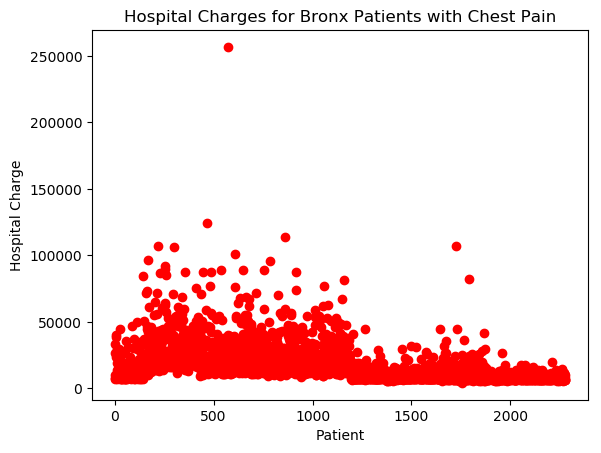

PyObject Text(0.5,1,u'Hospital Charges for Bronx Patients with Chest Pain')

In [66]:
sequential = zeros(length(BronxData[:, 1]), 1)
row = 1

while row < length(BronxData[:, 1])
    sequential[row] = row
    row = row + 1
end

scatter(sequential, BronxData[:, :Total_Charges] , color = "red")
xlabel("Patient")
ylabel("Hospital Charge")
title("Hospital Charges for Bronx Patients with Chest Pain")

#plot(Q, A[:, 2], label = "Length_of_Stay")

#hist(BronxData[:, :Total_Charges], 10)



2279


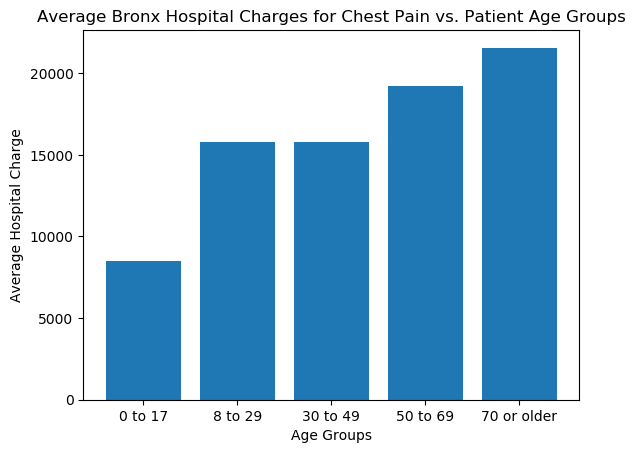

68
1.07315032e6
8489.031666666666
15781.622352941178
15769.621550000022
19214.782421410357
21564.42140186919
600
9.461772930000013e6


In [86]:
sequential = zeros(length(BronxData[:, 1]), 1)
row = 1


age0 = 0
age0Cost = 0
age1 = 0
age1Cost = 0
age2 = 0
age2Cost = 0
age3 = 0
age3Cost = 0
age4 = 0
age4Cost = 0


println(length(BronxData[: ,1]))

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 1] == 0)
        age0 = age0 + 1
        age0Cost = age0Cost + BronxData[row, :Total_Charges]
    end
end


for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 1] == 1)
        age1 = age1 + 1
        age1Cost = age1Cost + BronxData[row, :Total_Charges]
    end
end


for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 1] == 2)
        age2 = age2 + 1
        age2Cost = age2Cost + BronxData[row, :Total_Charges]
    end
end

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 1] == 3)
        age3 = age3 + 1
        age3Cost = age3Cost + BronxData[row, :Total_Charges]
    end
end

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 1] == 4)
        age4 = age4 + 1
        age4Cost = age4Cost + BronxData[row, :Total_Charges]
    end
end



println(age1)
println(age1Cost)
println(age0Cost/age0)


println(age1Cost/age1)
println(age2Cost/age2)
println(age3Cost/age3)
println(age4Cost/age4)


bar(["0 to 17", "8 to 29", "30 to 49", "50 to 69", "70 or older"], [age0Cost/age0, age1Cost/age1, age2Cost/age2,
        age3Cost/age3, age4Cost/age4])
xlabel("Age Groups")
ylabel("Average Hospital Charge")
title("Average Bronx Hospital Charges for Chest Pain vs. Patient Age Groups")

println(age2)
println(age2Cost)
#bar([""])


#bar([1], [age1Cost/age1])
#xlabel("Age Groups")
#ylabel("Hospital Charge")
#title("Hospital Charges for Bronx Patients with Chest Pain")
#

2279
987
1.5739822340000005e7
NaN
15947.135096251272
19472.35606113535
27920.625384615392
100727.3125


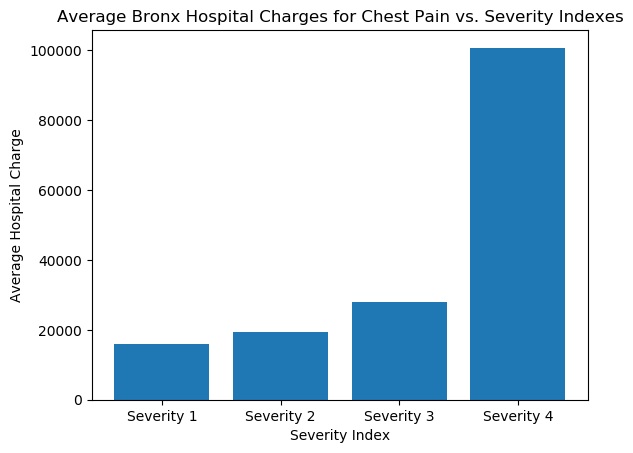

1145
2.2295847689999975e7


In [85]:
sequential = zeros(length(BronxData[:, 1]), 1)
row = 1


age0 = 0
age0Cost = 0
age1 = 0
age1Cost = 0
age2 = 0
age2Cost = 0
age3 = 0
age3Cost = 0
age4 = 0
age4Cost = 0


println(length(BronxData[: ,1]))

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 4] == 0)
        age0 = age0 + 1
        age0Cost = age0Cost + BronxData[row, :Total_Charges]
    end
end


for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 4] == 1)
        age1 = age1 + 1
        age1Cost = age1Cost + BronxData[row, :Total_Charges]
    end
end


for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 4] == 2)
        age2 = age2 + 1
        age2Cost = age2Cost + BronxData[row, :Total_Charges]
    end
end

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 4] == 3)
        age3 = age3 + 1
        age3Cost = age3Cost + BronxData[row, :Total_Charges]
    end
end

for row = 1:length(BronxData[:, 1])
    if (BronxData[row, 4] == 4)
        age4 = age4 + 1
        age4Cost = age4Cost + BronxData[row, :Total_Charges]
    end
end



println(age1)
println(age1Cost)
println(age0Cost/age0)


println(age1Cost/age1)
println(age2Cost/age2)
println(age3Cost/age3)
println(age4Cost/age4)


bar(["Severity 1", "Severity 2", "Severity 3", "Severity 4"], [age1Cost/age1, age2Cost/age2,
        age3Cost/age3, age4Cost/age4])
xlabel("Severity Index")
ylabel("Average Hospital Charge")
title("Average Bronx Hospital Charges for Chest Pain vs. Severity Indexes")

println(age2)
println(age2Cost)
#bar([""])


#bar([1], [age1Cost/age1])
#xlabel("Age Groups")
#ylabel("Hospital Charge")
#title("Hospital Charges for Bronx Patients with Chest Pain")
#

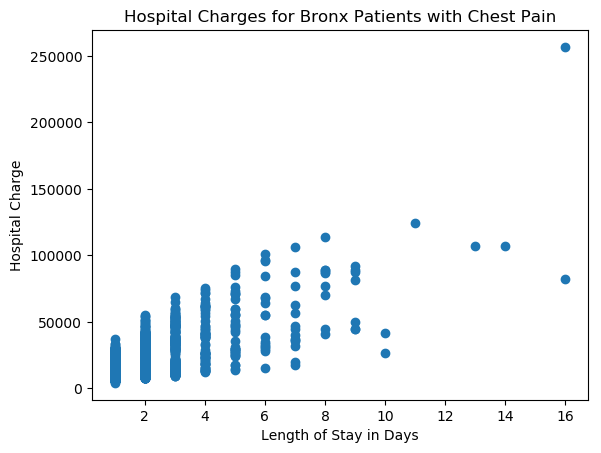

PyObject Text(0.5,1,u'Hospital Charges for Bronx Patients with Chest Pain')

In [34]:
sequential = zeros(length(BronxData[:, 1]), 1)
row = 1

while row < length(BronxData[:, 1])
    sequential[row] = row
    row = row + 1
end

scatter(BronxData[:, :2], BronxData[:, :Total_Charges])
xlabel("Length of Stay in Days")
ylabel("Hospital Charge")
title("Hospital Charges for Bronx Patients with Chest Pain")

#plot(Q, A[:, 2], label = "Length_of_Stay")

#hist(BronxData[:, :Total_Charges], 10)





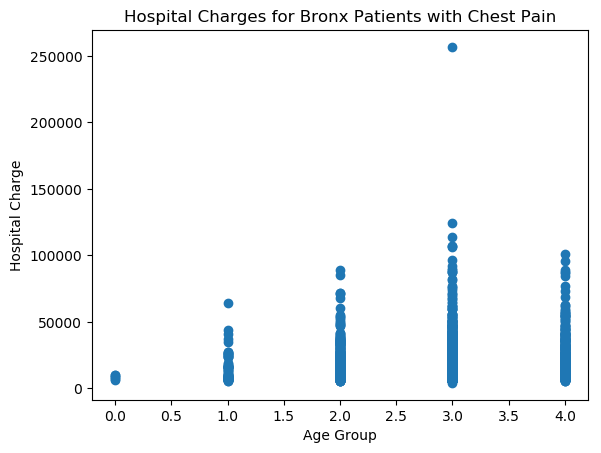

PyObject Text(0.5,1,u'Hospital Charges for Bronx Patients with Chest Pain')

In [35]:
sequential = zeros(length(BronxData[:, 1]), 1)
row = 1

while row < length(BronxData[:, 3])
    sequential[row] = row
    row = row + 1
end

scatter(BronxData[:, :1], BronxData[:, :Total_Charges])
xlabel("Age Group")
ylabel("Hospital Charge")
title("Hospital Charges for Bronx Patients with Chest Pain")

#plot(Q, A[:, 2], label = "Length_of_Stay")

#hist(BronxData[:, :Total_Charges], 10)






In [55]:
length(BronxData[: ,1])

2279

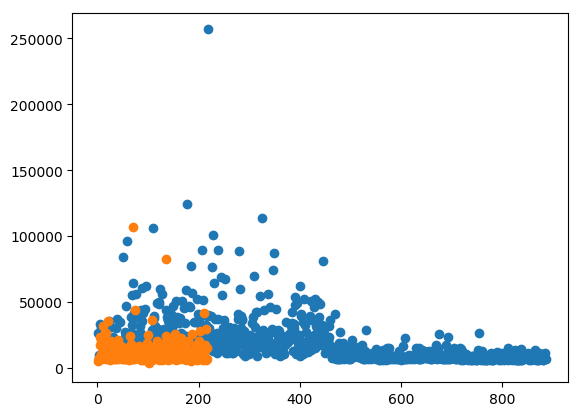

PyObject <matplotlib.collections.PathCollection object at 0x14d58ea10>

In [64]:
male = Float64[]
female = Float64[]
sequentialMale = Float64[]
sm = 1
sequentialFemale= Float64[]
sf = 1


for row = 1:length(BronxData[:, :15])
    if (BronxData[row, :15] == 1)
        push!(male, BronxData[row, :Total_Charges])
        push!(sequentialMale, sm)
        sm = sm + 1
    elseif (BronxData[row, :16] == 1)
        push!(female, BronxData[row, :Total_Charges])
        push!(sequentialFemale, sf)
        sf = sf + 1
    end
end


scatter(sequentialFemale, female)
scatter(sequentialMale, male)
#println(length(male))
#println(length(female))

In [ ]:
numberOfSeverity18 = 0
numberOfSeverity28 = 0
numberOfSeverity38 = 0
numberOfSeverity48 = 0

#BronxLebanon
for i = 1: length(xTrain[:, 8])
    if (xTrain[i, 8] == 1 && xTrain[i, 4] == 1)
        numberOfSeverity18 = numberOfSeverity18 + 1
    elseif (xTrain[i, 8] == 1 && xTrain[i, 4] == 2)
        numberOfSeverity28 = numberOfSeverity28 + 1
    elseif(xTrain[i, 8] == 1 && xTrain[i, 4] == 3)
        numberOfSeverity38 = numberOfSeverity38 + 1
    else(xTrain[i, 8] == 1 && xTrain[i, 4] == 4)
        numberOfSeverity48 = numberOfSeverity48 + 1
    end
end
println(numberOfSeverity18)
println(numberOfSeverity28)
println(numberOfSeverity38)
println(numberOfSeverity48)
println(length(xTrain[:, 8]))
println((numberOfSeverity48 + numberOfSeverity38)/length(xTrain[:, 8]))


#Jacobi Medical Center
numberOfSeverity19 = 0
numberOfSeverity29 = 0
numberOfSeverity39 = 0
numberOfSeverity49 = 0

for i = 1: length(xTrain[:, 9])
    if (xTrain[i, 9] == 1 && xTrain[i, 4] == 1)
        numberOfSeverity19 = numberOfSeverity19 + 1
    elseif (xTrain[i, 9] == 1 && xTrain[i, 4] == 2)
        numberOfSeverity29 = numberOfSeverity29 + 1
    elseif(xTrain[i, 9] == 1 && xTrain[i, 4] == 3)
        numberOfSeverity39 = numberOfSeverity39 + 1
        else(xTrain[i, 9] == 1 && xTrain[i, 4] == 4)
        numberOfSeverity49 = numberOfSeverity49 + 1
    end
end
#println(numberOfSeverity1)
#println(numberOfSeverity2)
#println(numberOfSeverity3)
#println(numberOfSeverity4)
#println(length(xTrain[:, 9]))
println((numberOfSeverity49 + numberOfSeverity39)/length(xTrain[:, 9]))


#MontefioreWakefield Center
numberOfSeverity10 = 0
numberOfSeverity20 = 0
numberOfSeverity30 = 0
numberOfSeverity40 = 0

for i = 1: length(xTrain[:, 10])
    if (xTrain[i, 10] == 1 && xTrain[i, 4] == 1)
        numberOfSeverity10 = numberOfSeverity10 + 1
    elseif (xTrain[i, 10] == 1 && xTrain[i, 4] == 2)
        numberOfSeverity20 = numberOfSeverity20 + 1
    elseif(xTrain[i, 10] == 1 && xTrain[i, 4] == 3)
        numberOfSeverity30 = numberOfSeverity30 + 1
        else(xTrain[i, 10] == 1 && xTrain[i, 4] == 4)
        numberOfSeverity40 = numberOfSeverity40 + 1
    end
end
#println(numberOfSeverity1)
#println(numberOfSeverity2)
#println(numberOfSeverity3)
#println(numberOfSeverity40)
#println(length(xTrain[:, 10]))
println((numberOfSeverity40 + numberOfSeverity30)/length(xTrain[:, 10]))


#Calvary Center
numberOfSeverity13 = 0
numberOfSeverity23 = 0
numberOfSeverity33 = 0
numberOfSeverity43 = 0

for i = 1: length(xTrain[:, 10])
    if (xTrain[i, 13] == 1 && xTrain[i, 4] == 1)
        numberOfSeverity10 = numberOfSeverity10 + 1
    elseif (xTrain[i, 13] == 1 && xTrain[i, 4] == 2)
        numberOfSeverity20 = numberOfSeverity20 + 1
    elseif(xTrain[i, 13] == 1 && xTrain[i, 4] == 3)
        numberOfSeverity33 = numberOfSeverity33 + 1
        else(xTrain[i, 13] == 1 && xTrain[i, 4] == 4)
        numberOfSeverity43 = numberOfSeverity43 + 1
    end
end
#println(numberOfSeverity1)
#println(numberOfSeverity2)
#println(numberOfSeverity3)
#println(numberOfSeverity40)
#println(length(xTrain[:, 10]))
println((numberOfSeverity43 + numberOfSeverity33)/length(xTrain[:, 13]))

println("33")
println(numberOfSeverity33)
println("43")
println(numberOfSeverity43)


bar(["BronxLebanon", "JacobiCenter", "MontefioreWakefield", "Calvary"], 
    [numberOfSeverity48/length(xTrain[:, 8]), numberOfSeverity49/length(xTrain[:, 9]), 
        numberOfSeverity40/length(xTrain[:, 10]), numberOfSeverity43/length(xTrain[:, 13]) ])

xlabel("Hospital Name")
ylabel("Percentage of ")




In [30]:
#PyPlot.plt.hist(BronxData[:, :Total_Charges], 10)



In [31]:
#=BronxData = delete!(BronxData, :BronxLebanonHospitalCenterConcourseDivision)
BronxData = delete!(BronxData, :JacobiMedicalCenter)
BronxData = delete!(BronxData, :MontefioreMedicalCenterWakefieldHospital)
BronxData = delete!(BronxData, :MontefioreMedicalCenterHenryLucyMosesDiv)
BronxData = delete!(BronxData, :LincolnMedicalMentalHealthCenter)
BronxData = delete!(BronxData, :CalvaryHospitalInc)
BronxData = delete!(BronxData, :SBHHealthSystem)
BronxData = delete!(BronxData, :BlackAfricanAmerican)
BronxData = delete!(BronxData, :OtherRace)
BronxData = delete!(BronxData, :White)
BronxData = delete!(BronxData, :Multi)
BronxData = delete!(BronxData, :Unknown)
=#


#=BronxData2
size(BronxData2)
println("Test")
println(BronxData2[456, :])

println("Training")
println(BronxData[2279, :])
=#


#There are a total of 2279 rows
#We will put 1-1823 in the training set, and the rest in the test

#NEED TO ADD THE ADITIONAL ONES FEATURES IN HERE!!

#=
sample = randsubseq(1:size(BronxData,1), 0.80)
trainingset = BronxData[sample, :]
notsample = [i for i in 1:size(BronxData,1) if isempty(searchsorted(BronxData, i))]
testset = BronxData[notsample, :]
=#

xData = BronxData
yData = xData[:, :Total_Charges]
xData = delete!(xData, :Total_Charges)

labelList = Symbol[]
for i=1:21
    push!(labelList, names(xData)[i])
end
labelList

xData = convert(Array, xData)
yData = convert(Array, yData)

fullData = [copy(xData[:, :]) yData]
fullDataShuffled = fullData[shuffle(1:end), :]

fullDataShuffled



xTrain = fullDataShuffled[1:1814, 1:21]
xTrain = [copy(xTrain[:, :]) ones(length(xTrain[:,1]))]
yTrain = fullDataShuffled[1:1814, 22]


xTest = fullDataShuffled[1815:2268, 1:21]
xTest = [copy(xTest[:, :]) ones(length(xTest[:,1]))]
yTest = fullDataShuffled[1815: 2268, 22]


w = xTrain\yTrain


#=
labelList = Symbol[]
for i=1:20
    push!(labelList, names(xTrain)[i])
end
labelList
=#

#=
xTrain = convert(Array, xTrain)
xTrain = [copy(xTrain[:, :]) ones(length(xTrain[:,1]))]
yTrain = convert(Array, yTrain)

xTest = tail(BronxData, 2279 - 1823)
yTest = xTest[:, :Total_Charges]
xTest = delete!(xTest, :Total_Charges)

xTest = convert(Array, xTest)
xTest = [copy(xTest[:, :]) ones(length(xTest[:,1]))]
yTest = convert(Array, yTest)

w = xTrain\yTrain
=#

#typeof(yTrain)

#=
labelList = Symbol[]
for i=1:20
    push!(labelList, names(xTrain)[i])
end
labelList


xTrain = convert(Array, xTrain)
yTrain = convert(Array, yTrain)
=#

#w = xTrain\yTrain


#=xTest = tail(BronxData, 2279 - 1823)
yTest = xTest[:, :Total_Charges]
xTest = delete!(xTest, :Total_Charges)

xTrain = [copy(xTrain[:, :]) ones(length(xTrain[:,1]))]
xTest = [copy(xTest[:, :]) ones(length(xTest[:,1]))]

xTrain = convert(Array, xTrain)
yTrain = convert(Array, yTrain)

w = xTrain\yTrain
=#

22-element Array{Float64,1}:
   -30.0538
  6780.76  
  1868.57  
    78.9064
   495.231 
  -661.564 
  1265.93  
 -7782.22  
 -4362.52  
 13244.4   
  8678.55  
 -4533.29  
     0.0   
 -5906.43  
   -64.5444
  -597.02  
  1734.87  
  1803.43  
  1319.77  
     0.0   
     0.0   
  -661.564 

In [33]:
fullDataShuffled[1, :]

22-element Array{Float64,1}:
     4.0
     2.0
     2.0
     1.0
     0.0
     1.0
     1.0
     0.0
     0.0
     0.0
     1.0
     0.0
     0.0
     0.0
     0.0
     1.0
     1.0
     0.0
     0.0
     0.0
     0.0
 32588.3

In [34]:
for i=1:21
    println(labelList[i])
    println(w[i])
end
w[22]

Age_Group
-30.053797972686393
Length_of_Stay
6780.762067579903
Type_of_Admission
1868.5679505216644
APR_Severity_of_Illness_Code
78.90636034302797
APR_Risk_of_Mortality
495.2314118214199
APR_Medical_Surgical_Description
-661.564492687407
Emergency_Department_Indicator
1265.9287097015738
BronxLebanonHospitalCenterConcourseDivision
-7782.22360388665
JacobiMedicalCenter
-4362.516355728257
MontefioreMedicalCenterWakefieldHospital
13244.351810448907
MontefioreMedicalCenterHenryLucyMosesDiv
8678.551007126078
LincolnMedicalMentalHealthCenter
-4533.292713843834
CalvaryHospitalInc
0.0
SBHHealthSystem
-5906.434636803662
Male
-64.54442316465754
Female
-597.0200695227489
BlackAfricanAmerican
1734.867540702499
OtherRace
1803.425015612103
White
1319.7659738230511
Multi
0.0
Unknown
0.0


-661.5644926873956

In [35]:
#**************************************** Calculate Prediction ****************************************#
function calculatePrediction(x, w)
    prediction = 0
    x = convert(Array, x)
    w = convert(Array, w)
    for index = 1: 21
        prediction = prediction + w[index]*x[index]
    end
    return (prediction + w[22])
end

#**************************************** Calculate Error Function ****************************************#


#Calculating error percentage error

function calculateError(x,y,w)
    prediction = 0
    predictionList = Float64[]
    errorList = Float64[]
    
    for row = 1: length(x[:, 1])
        xArray = convert(Array, x[row, :])
        #y = convert(Array, y[row, :])
        prediction = calculatePrediction(xArray, w)
        error = (abs(prediction - y[row])/(y[row])) * 100
        push!(errorList, error)
    end
    
    errorSum = 0
    for n = 1: length(errorList[: , 1])
        errorSum = errorSum + errorList[n]
    end
    
    return (errorSum/length(errorList[: , 1]))
end


#****************************************** Calculate Range Error  ******************************************#


function calculateRangeError(x,y,w)
    prediction = 0
    predictionList = Float64[]
    errorList = Float64[]

    #errorList = Float64[]
    
    for row = 1: length(x[:, 1])
        xArray = convert(Array, x[row, :])
        prediction = calculatePrediction(xArray, w)
        if (prediction < 0.9 * y[row])
            actual = y[row] * 0.9
            error = (abs(prediction - actual)/(actual)) * 100
            push!(errorList, error)
        elseif (prediction > 1.1 * y[row])
            actual = y[row] * 1.1
            error = (abs(prediction - actual)/(actual)) * 100
            push!(errorList, error)
        else
            error = (abs(prediction - y[row])/(y[row])) * 100
            push!(errorList, error)
        end
    end
    
    errorSum = 0
    for n = 1: length(errorList[: , 1])
        errorSum = errorSum + errorList[n]
    end
    
    return (errorSum/length(x[:, 1]))
end

#*************************************** Calculate Root Mean Square Error  ***************************************#


function calculateRMSE(x,y,w)
    prediction = 0
    predictionList = Float64[]
    errorList = Float64[]

    #errorList = Float64[]
    
    for row = 1: length(x[:, 1])
        xArray = convert(Array, x[row, :])
        prediction = calculatePrediction(xArray, w)
        error = (prediction - y[row])^2 
        push!(errorList, error)
    end
    
    errorSum = 0
    for n = 1: length(errorList[: , 1])
        errorSum = errorSum + errorList[n]
    end
    
    mse = errorSum/(length(x[:, 1]))
    rmse = sqrt(mse)
    return rmse
end


#*************************************** Calculate RSquare  ***************************************#


function calculateRSquare(x,y,w)
    prediction = 0
    predictionList = Float64[]
    errorListSSE = Float64[]
    errorListSSTO = Float64[]
    
    trueMean = 0
    for row = 1: length(y[:, 1])
       trueMean = trueMean + y[row]
    end
    trueMean = trueMean/(length(y[:, 1]))
    

    for row = 1: length(x[:, 1])
        xArray = convert(Array, x[row, :])
        prediction = calculatePrediction(xArray, w)
        errorSSE = (prediction - y[row])^2 
        errorSSTO = (trueMean - y[row])^2
        push!(errorListSSE, errorSSE)
        push!(errorListSSTO, errorSSTO)
    end
    
    SSE = 0
    for n = 1: length(errorListSSE[: , 1])
        SSE = SSE + errorListSSE[n]
    end
    
    SSTO = 0
    for n = 1: length(errorListSSTO[: , 1])
        SSTO = SSTO + errorListSSTO[n]
    end
    
    rSquare = 1 - (SSE/SSTO)
    return rSquare
end


#**************************************** Testing Error Function ****************************************#
#Calculating error percentage error

function testingCalculateError(x,y,w)
    prediction = 0
    predictionList = Float64[]
    errorList = Float64[]
    
    for row = 1:2
        xArray = convert(Array, x[row, :])
        prediction = calculatePrediction(xArray, w)
        push!(predictionList, prediction)
        error = (abs(prediction - y[row])/(y[row])) * 100
        push!(errorList, error)
    end
    
    errorSum = 0
    for n = 1: length(errorList[: , 1])
        errorSum = errorSum + errorList[n]
    end
    
    #= Debugging to check error function is correct
    println("predictionList")
    println(predictionList)
    println("errorList")
    println(errorList)
    =#
    
    return (errorSum/length(errorList[: , 1]))
end

#**************************************** Percent Error for Backslash Operator ******************************#
#=
println("First Test Prediction")
println(calculatePrediction(xTest[1, :], w))
println("First Test Actual Value")
println(yTest[1])

println("One-Two Test Percent Error:")
println(calculateError(xTest[1:2, :], yTest[1:2, :], w))
=#

#=
for i = 1:length(xTrain[:, 1])
    println(calculatePrediction(xTest[i, :], w))
    println(yTest[i])
end
=#

println("Overall Training Error for just Backslash w")
println(calculateError(xTrain[:, :], yTrain[:, :], w))
    
println("Overall Training Range Error for just Backslash w")
println(calculateRangeError(xTrain[:, :], yTrain[:, :], w))

println("Overall Test Error for just Backslash w")
println(calculateError(xTest[:, :], yTest[:, :], w))
    
println("Overall Test Range Error for just Backslash w")
println(calculateRangeError(xTest[:, :], yTest[:, :], w))


println("RMSE")
println(calculateRMSE(xTest[:, :], yTest[:, :], w))

println("rSquare")
println(calculateRSquare(xTest[:, :], yTest[:, :], w))

#=
for i = 1:5
    xRow = convert(Array, xTrain[i, :])
    println("Prediction")
    println(calculatePrediction(xRow, w))
    println("Actual")
    println(yTrain[i])
end

println("Overall Training Error for just first 5 Backslash w")
println(calculateError(xTrain[1:5, :], yTrain[:, :], w))
println("Overall Range Training Error for just first 5 Backslash w")
println(calculateRangeError(xTrain[1:5, :], yTrain[:, :], w))
=#


Overall Training Error for just Backslash w
24.220406838899006
Overall Training Range Error for just Backslash w
16.984307283220993
Overall Test Error for just Backslash w
27.510149097644998
Overall Test Range Error for just Backslash w
19.596732771111636
RMSE
7323.394532030357
rSquare
0.76489273889554


# L1 Loss Regression - L1 Loss Function with No Regularizer

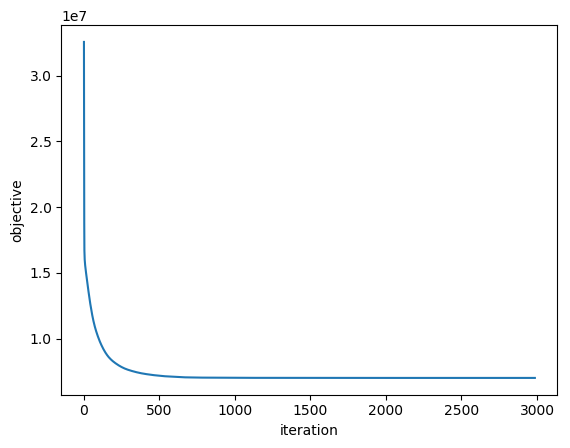

22-element Array{Float64,1}:
  -154.281 
  6154.02  
  1641.4   
    76.5659
   102.851 
   766.781 
    94.1805
 -5404.24  
 -3635.71  
 10648.9   
  7843.66  
 -4048.01  
     0.0   
 -4637.83  
   493.972 
   272.808 
   409.527 
   417.721 
   211.868 
     0.0   
     0.0   
   766.781 

In [36]:
#xTrain = convert(Array, xTrain)
#xTrain = convert(Array{Float64,2}, xTrain)

ch = ConvergenceHistory("L1Loss")
w_l1 = proxgrad(L1Loss(), ZeroReg(), xTrain, yTrain; stepsize=.1, maxiters = 3000, ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

w_l1

# Plot for Training Data for w_l1 - Actual

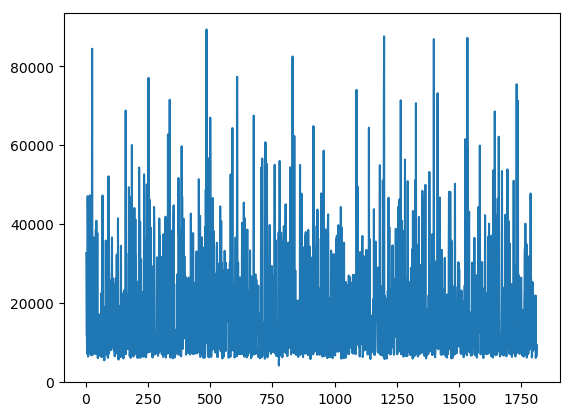

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x126597b90>

In [37]:
sequential = Float64[]
for i = 1: length(yTrain[:, 1])  #50
    push!(sequential, i)
end

#=
predictionList = Float64[]
    for i = 1:length(yTrain[:, 1])
        push!(predictionList, calculatePrediction(xTrain[i, :], w_l1))
    end
predictionList
=#

#plot(sequential, predictionList)
plot(sequential, yTrain)

# Plot for Training Data for w_l1 - Predictions

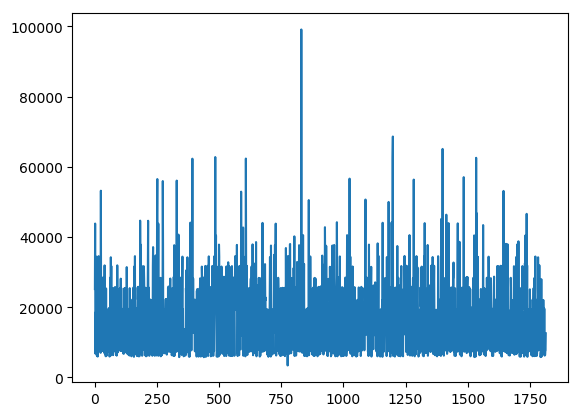

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14cd90990>

In [38]:
sequential = Float64[]
for i = 1: length(yTrain[:, 1])  #50
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:length(yTrain[:, 1])
        push!(predictionList, calculatePrediction(xTrain[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
#plot(sequential, yTrain)

# Plot for Test Data for w_l1 - Actual

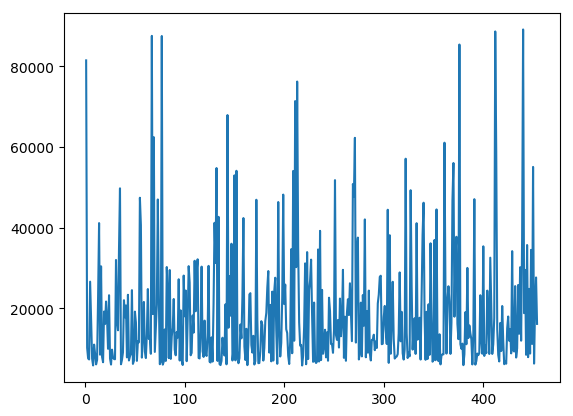

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d3e0f50>

In [39]:
sequential = Float64[]
for i = 1: length(yTest[:, 1])
    push!(sequential, i)
end

#=
predictionList = Float64[]
    for i = 1:length(yTest[:, 1])
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList
=#

#plot(sequential, predictionList)
plot(sequential, yTest)

# Plot for Test Data for w_l1 - Prediction

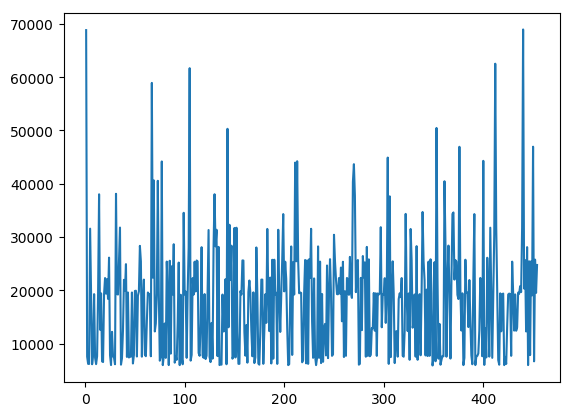

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d451b90>

In [40]:
predictionList = Float64[]
    for i = 1:length(yTest[:, 1])
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList


plot(sequential, predictionList)

# Plot for Test Data for w_l1 -  Actual & Predictions

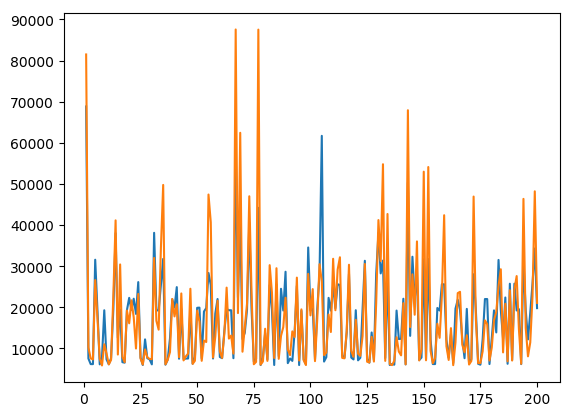

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d56a7d0>

In [41]:
#= FOR ALL
sequential = Float64[]
for i = 1:length(yTest[:, 1])
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:length(yTest[:, 1])
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
plot(sequential, yTest[:, :])
=#

sequential = Float64[]
for i = 1:200
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:200
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
plot(sequential, yTest[1:200])

# Plot for Training Data for w_l1 - First 50 Actual

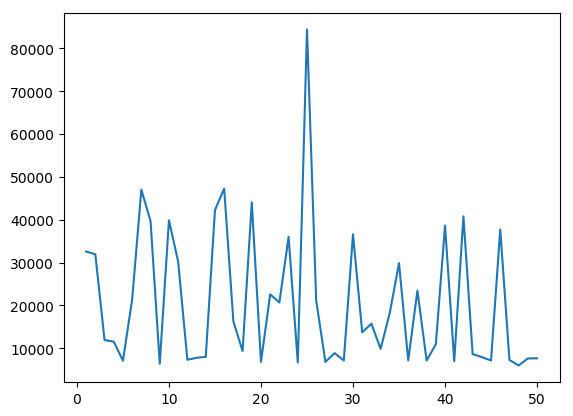

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d7bcb10>

In [43]:
sequential = Float64[]
for i = 1: 50
    push!(sequential, i)
end


predictionList = Float64[]
    for i = 1:50
        push!(predictionList, calculatePrediction(xTrain[i, :], w_l1))
    end
predictionList


#plot(sequential, predictionList)
plot(sequential, yTrain[1:50])

# Plot for Training Data for w_l1 - First 50 Predictions

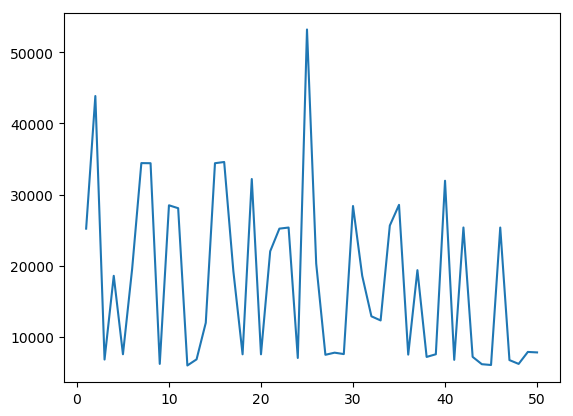

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d8460d0>

In [44]:
sequential = Float64[]
for i = 1:50
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:50
        push!(predictionList, calculatePrediction(xTrain[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
#plot(sequential, yTrain)

# Plot for Training Data for w_l1 - First 50 Actual & Predictions


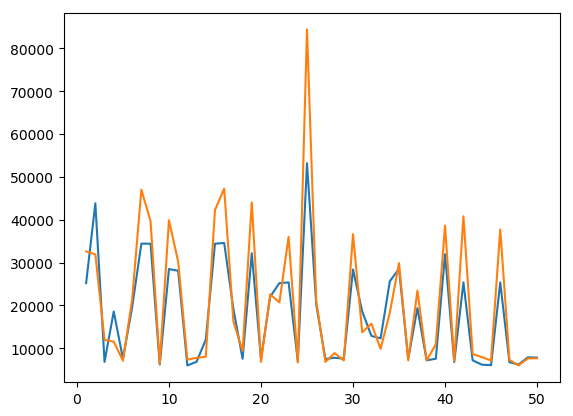

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x152323510>

In [45]:
sequential = Float64[]
for i = 1:50
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:50
        push!(predictionList, calculatePrediction(xTrain[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
plot(sequential, yTrain[1:50])

# Plot for Test Data for w_l1 - First 50 Actual

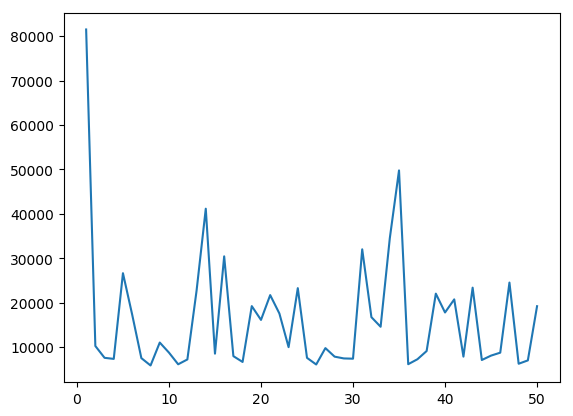

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d8c0cd0>

In [46]:
sequential = Float64[]
for i = 1: 50
    push!(sequential, i)
end

#=
predictionList = Float64[]
    for i = 1:length(yTest[:, 1])
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList
=#

#plot(sequential, predictionList)
plot(sequential, yTest[1:50])

# Plot for Test Data for w_l1 - First 50 Predictions


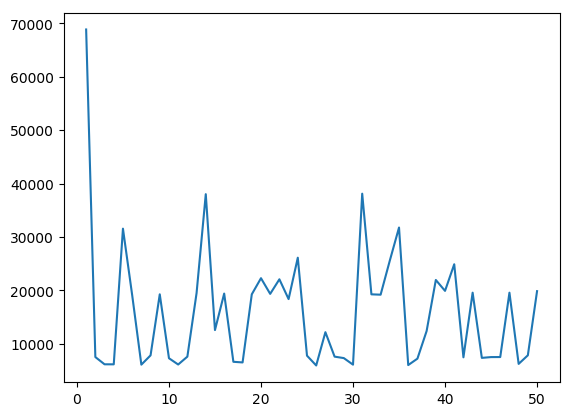

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14da33290>

In [47]:
sequential = Float64[]
for i = 1:50
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:50
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList)
#plot(sequential, yTrain)

# Plot for Test Data for w_l1 - First 50 Actual & Predictions

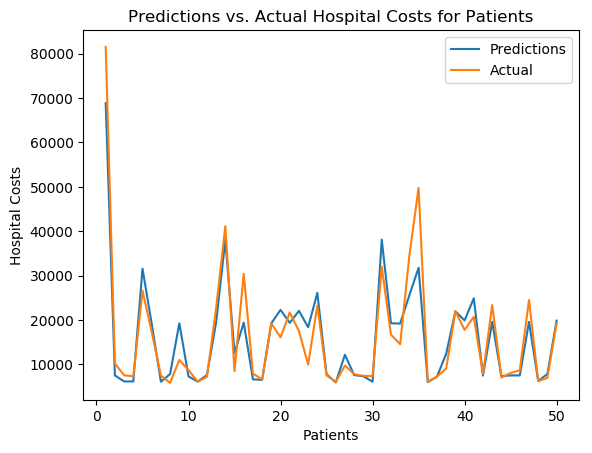

PyObject <matplotlib.legend.Legend object at 0x14db82050>

In [48]:
sequential = Float64[]
for i = 1:50
    push!(sequential, i)
end

predictionList = Float64[]
    for i = 1:50
        push!(predictionList, calculatePrediction(xTest[i, :], w_l1))
    end
predictionList

plot(sequential, predictionList, label = "Predictions")
plot(sequential, yTest[1:50], label = "Actual")

xlabel("Patients")
ylabel("Hospital Costs")
title("Predictions vs. Actual Hospital Costs for Patients")
legend()

# Training & Test Error with L1 Objective Loss Function & No Regularization (First 50)

In [49]:
println("First 50 Training Error with L1 Objective Loss Function")
println(calculateError(xTrain[1:50, :], yTrain[1:50, :], w_l1))

println("First 50 Test Error with L1 Objective Loss Function")
println(calculateError(xTest[1:50, :], yTest[1:50, :], w_l1))

First 50 Training Error with L1 Objective Loss Function
18.959922627526417
First 50 Test Error with L1 Objective Loss Function
17.65610446541776


# Training & Test Error with L1 Objective Loss Function & No Regularization (Overall)

In [50]:
println("Training Error with L1 Objective Loss Function")
println(calculateError(xTrain, yTrain, w_l1))

println("Test Error with L1 Objective Loss Function")
println(calculateError(xTest, yTest, w_l1))

println("Train RangeError with L1 Objective Loss Function")
println(calculateRangeError(xTrain, yTrain, w_l1))

println("Test RangeError with L1 Objective Loss Function")
println(calculateRangeError(xTest, yTest, w_l1))

println("RSquare Value")
println(calculateRSquare(xTest, yTest, w_l1))

Training Error with L1 Objective Loss Function
20.273223782114936
Test Error with L1 Objective Loss Function
23.35471271817353
Train RangeError with L1 Objective Loss Function
13.700886255882502
Test RangeError with L1 Objective Loss Function
16.100825135411064
RSquare Value
0.7350536600573323


# L1 Loss  L1 Regularizer Regression - L1 Loss Function with L1 Regularizer

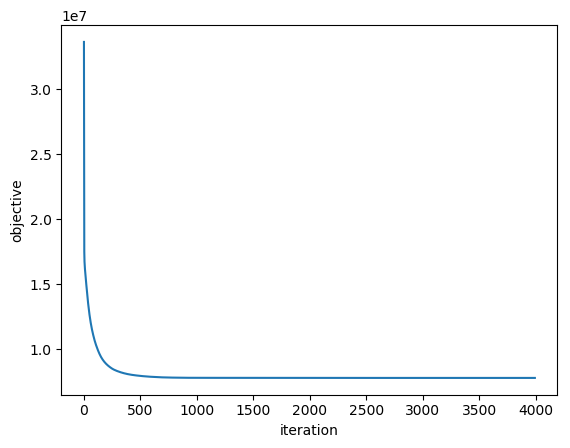

22-element Array{Float64,1}:
  -188.308  
  6341.15   
  1520.43   
   228.028  
     5.96719
   615.174  
   588.612  
 -5374.12   
 -3578.46   
 10706.9    
  7778.61   
 -3894.34   
     0.0    
 -4727.23   
   366.878  
   146.616  
   152.06   
   273.075  
   242.8    
     0.0    
     0.0    
   615.174  

In [23]:
ch = ConvergenceHistory("L1LossL1Reg")

lambda = 6
w_l1_r1 = proxgrad(L1Loss(), OneReg(lambda), xTrain, yTrain; stepsize=.1, maxiters = 4000, ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

w_l1_r1

In [24]:
for i=1:20
    println(labelList[i])
    println(w_l1_r1[i])
end
println(w_l1_r1[21])

Age_Group
-188.3078125000209
Length_of_Stay
6341.152343748992
Type_of_Admission
1520.4281250001914
APR_Severity_of_Illness_Code
228.02812500000547
APR_Risk_of_Mortality
5.967187500000995
APR_Medical_Surgical_Description
615.1742187499019
Emergency_Department_Indicator
588.611718749927
BronxLebanonHospitalCenterConcourseDivision
-5374.117187499566
JacobiMedicalCenter
-3578.460937500222
MontefioreMedicalCenterWakefieldHospital
10706.949999998875
MontefioreMedicalCenterHenryLucyMosesDiv
7778.607812499066
LincolnMedicalMentalHealthCenter
-3894.338281250621
CalvaryHospitalInc
0.0
SBHHealthSystem
-4727.228124999119
Male
366.8781249999481
Female
146.61640625002286
BlackAfricanAmerican
152.0601562500194
OtherRace
273.07499999992683
White
242.8000000000262
Multi
0.0
0.0


# Errors with L1 Loss L1 Regularizer Regression - L1 Loss Function with L1 Regularizer (First 50)

In [25]:
println("Training Error with L1 Objective Loss Function")
println(calculateError(xTrain[1:50, :], yTrain[1:50, :], w_l1_r1))

println("Test Error with L1 Objective Loss Function")
println(calculateError(xTest[1:50, :], yTest[1:50, :], w_l1_r1))

Training Error with L1 Objective Loss Function
23.384521957461317
Test Error with L1 Objective Loss Function
22.06132781234517


# Errors with L1 Loss L1 Regularizer Regression - L1 Loss Function with L1 Regularizer (Overall)

In [53]:
println("Training Error with L1 Objective Loss Function & L1 Regularizer")
println(calculateError(xTrain, yTrain, w_l1_r1))

println("Test Error with L1 Objective Loss Function & L1 Regularizer")
println(calculateError(xTest, yTest, w_l1_r1))

println("Training RangeError with L1 Objective Loss Function")
println(calculateRangeError(xTrain, yTrain, w_l1_r1))

println("Test RangeError with L1 Objective Loss Function")
println(calculateRangeError(xTest, yTest, w_l1_r1))

println("rSquare Error")
println(calculateRSquare(xTest, yTest, w_l1_r1))

Training Error with L1 Objective Loss Function & L1 Regularizer
20.97717174104464
Test Error with L1 Objective Loss Function & L1 Regularizer
21.823214071585397
Training RangeError with L1 Objective Loss Function
14.224855361542383
Test RangeError with L1 Objective Loss Function
15.182841160809186
rSquare Error
0.7646696360593386


# L1 Loss with Quad Regularizer Regression

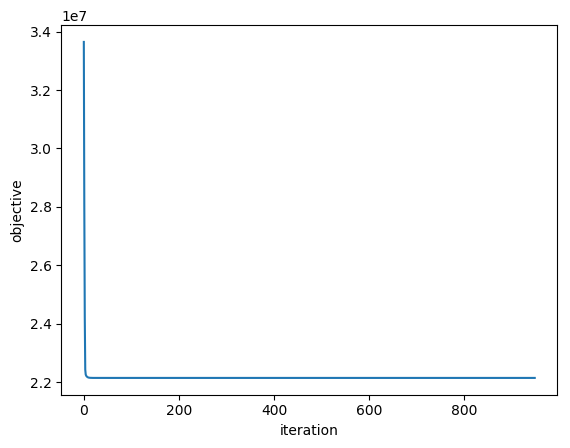

22-element Array{Float64,1}:
 1099.35   
  995.207  
  808.451  
  685.665  
  125.953  
  404.226  
  378.263  
  -59.7811 
   20.0328 
  116.755  
  302.365  
   -2.68413
    0.0    
   27.5385 
  172.518  
  231.708  
  149.481  
  201.274  
   54.9623 
    0.0    
    0.0    
  404.226  

In [27]:
ch = ConvergenceHistory("L1LossQuadReg")

lambda = 1
w_l1_qr = proxgrad(L1Loss(), QuadReg(lambda), xTrain, yTrain; stepsize=.1, maxiters = 1000, ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

w_l1_qr

In [28]:
println("Overall Training Error with L1 Objective Loss Function & Quad Regularizer")
println(calculateError(xTrain, yTrain, w_l1_qr))

println("Overall Test Error with L1 Objective Loss Function & Quad Regularizer")
println(calculateError(xTest, yTest, w_l1_qr))

Overall Training Error with L1 Objective Loss Function & Quad Regularizer
38.26569038860751
Overall Test Error with L1 Objective Loss Function & Quad Regularizer
39.16945323682087


# L1 Loss with Nonegative Constraint

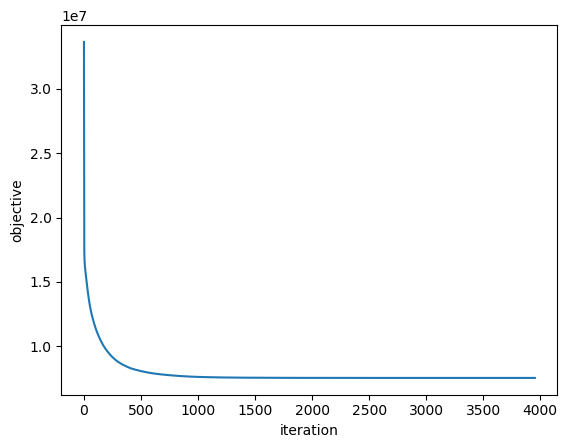

22-element Array{Float64,1}:
     0.0    
  6194.66   
     0.0    
     9.05958
     4.4    
     0.0    
     0.0    
     0.0    
  1507.16   
 16819.4    
 13001.5    
  1242.98   
     0.0    
   278.458  
   163.221  
     0.0    
     0.0    
     0.0    
    94.0    
     0.0    
     0.0    
     0.0    

In [29]:
ch = ConvergenceHistory("L1LossL1Reg")

lambda = 6
w_l1_nc = proxgrad(L1Loss(), NonNegConstraint(), xTrain, yTrain; stepsize=.1, maxiters = 4000, ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

w_l1_nc

In [30]:
for i=1:21
    println(labelList[i])
    println(w_l1_nc[i])
end
w_l1_nc[22]    

Age_Group
0.0
Length_of_Stay
6194.659999999966
Type_of_Admission
0.0
APR_Severity_of_Illness_Code
9.059583333895262
APR_Risk_of_Mortality
4.399999999999609
APR_Medical_Surgical_Description
0.0
Emergency_Department_Indicator
0.0
BronxLebanonHospitalCenterConcourseDivision
0.0
JacobiMedicalCenter
1507.1604166661261
MontefioreMedicalCenterWakefieldHospital
16819.44999999731
MontefioreMedicalCenterHenryLucyMosesDiv
13001.490833332318
LincolnMedicalMentalHealthCenter
1242.9795833325431
CalvaryHospitalInc
0.0
SBHHealthSystem
278.458333332902
Male
163.22124999969492
Female
0.0
BlackAfricanAmerican
0.0
OtherRace
0.0
White
94.00000000000706
Multi
0.0
Unknown
0.0


0.0

In [31]:
println("Overall Training Error with L1 Objective Loss Function & Non-Negative Constraint")
println(calculateError(xTrain, yTrain, w_l1_nc))
println(calculateRangeError(xTrain, yTrain, w_l1_nc))


println("Overall Test Error with L1 Objective Loss Function & Non-Negative Constraint")
println(calculateError(xTest, yTest, w_l1_nc))
println(calculateRangeError(xTest, yTest, w_l1_nc))

Overall Training Error with L1 Objective Loss Function & Non-Negative Constraint
21.065433767885715
14.335799705216255
Overall Test Error with L1 Objective Loss Function & Non-Negative Constraint
21.71985091034791
15.175409823431377


# Looking at Huber Loss

In [45]:
w_huber = proxgrad(HuberLoss(), OneReg(), xTrain, yTrain, maxiters=10000)

22-element Array{Float64,1}:
  -167.248 
  6338.97  
  1495.16  
   210.879 
     0.0   
   566.957 
   942.341 
 -5441.83  
 -3766.25  
 11494.1   
  7690.84  
 -3976.75  
     0.0   
 -4925.9   
   298.416 
    96.7747
    66.3964
   158.404 
   183.936 
     0.0   
     0.0   
   566.957 

In [46]:
println("Overall Training Error with Huber")
println(calculateError(xTrain, yTrain, w_huber))
println(calculateRangeError(xTrain, yTrain, w_huber))


println("Overall Test Error with Huber")
println(calculateError(xTest, yTest, w_huber))
println(calculateRangeError(xTest, yTest, w_huber))

Overall Training Error with Huber
21.042117982845824
14.321136363292453
Overall Test Error with Huber
21.952751404798654
15.233971141479849


# Looking at Quantile Regression:

In [32]:
w_quantile05 = proxgrad(QuantileLoss(quantile= 0.05), ZeroReg(), xTrain, yTrain, maxiters=10000)

22-element Array{Float64,1}:
    29.3664
  3251.96  
   927.854 
    67.4456
   158.249 
   442.902 
   913.848 
 -3263.7   
  -302.258 
  2797.63  
  3519.93  
  -864.394 
     0.0   
 -1444.3   
   212.356 
   230.546 
   289.697 
   341.162 
  -102.708 
     0.0   
     0.0   
   442.902 

In [33]:
println("Overall Training Error with Quantile 5%")
println(calculateError(xTrain, yTrain, w_quantile05))

println("Overall Test Error with Quantile 5%")
println(calculateError(xTest, yTest, w_quantile05))

Overall Training Error with Quantile 5%
31.463015867345828
Overall Test Error with Quantile 5%
32.29347939159154


In [34]:
w_quantile25 = proxgrad(QuantileLoss(quantile= 0.25), ZeroReg(), xTrain, yTrain, maxiters=10000)

22-element Array{Float64,1}:
   -55.101 
  5200.06  
   918.069 
   162.221 
    13.1706
   481.085 
  1110.86  
 -6127.55  
 -1952.23  
  8626.07  
  6057.98  
 -2606.07  
     0.0   
 -3517.11  
   324.423 
   156.662 
   106.94  
   314.823 
   229.984 
     0.0   
     0.0   
   481.085 

In [35]:
println("Overall Training Error with Quantile 25%")
println(calculateError(xTrain, yTrain, w_quantile25))

println("Overall Test Error with Quantile 25%")
println(calculateError(xTest, yTest, w_quantile25))

Overall Training Error with Quantile 25%
22.576057740829704
Overall Test Error with Quantile 25%
23.81070865163088


In [36]:
w_quantile50 = proxgrad(QuantileLoss(quantile= 0.5), ZeroReg(), xTrain, yTrain, maxiters=10000)

22-element Array{Float64,1}:
  -185.238 
  6322.66  
  1448.61  
   220.988 
    10.1116
   628.307 
   748.049 
 -5495.57  
 -3736.36  
 11098.0   
  7693.44  
 -4024.4   
     0.0   
 -4906.8   
   421.176 
   207.131 
   200.433 
   311.709 
   286.354 
     0.0   
     0.0   
   628.307 

In [37]:
println("Overall Training Error with Quantile 50%")
println(calculateError(xTrain, yTrain, w_quantile50))

println("Overall Test Error with Quantile 50%")
println(calculateError(xTest, yTest, w_quantile50))

Overall Training Error with Quantile 50%
21.018174884346504
Overall Test Error with Quantile 50%
21.896834872155438


In [38]:
q = 0.05
A = zeros(19, 22)
i = 1

while q < 1.00
    A[i, :] = proxgrad(QuantileLoss(quantile= q), ZeroReg(), xTrain, yTrain, maxiters=10000)
    i = i + 1
    q = q + 0.05
end

A

19×22 Array{Float64,2}:
   29.3664   3251.96   927.854   67.4456  …  -102.708   0.0  0.0  442.902
  -22.9243   4512.1    789.881   62.7705     -128.53    0.0  0.0  398.263
  -23.5275   4848.35   820.381  101.53         48.8442  0.0  0.0  390.743
  -23.1148   5082.33   852.689  130.221        90.6176  0.0  0.0  431.628
  -55.101    5200.06   918.069  162.221       229.984   0.0  0.0  481.085
  -78.8756   5338.92  1045.75   134.633   …   317.641   0.0  0.0  560.799
 -131.872    5466.12  1154.48    49.3167      419.184   0.0  0.0  582.737
 -100.786    5807.81  1276.02   145.069       290.402   0.0  0.0  543.517
 -130.926    6127.71  1340.81   160.401       331.804   0.0  0.0  577.601
 -186.152    6321.87  1452.73   221.18        287.23    0.0  0.0  630.363
 -209.212    6630.15  1555.62   357.613   …   318.58    0.0  0.0  670.936
 -252.377    6768.24  1616.0    477.314       385.616   0.0  0.0  702.667
 -290.668    6935.82  1669.23   612.421       334.751   0.0  0.0  700.369
 -361.612    7

In [39]:
Q = zeros(19, 1)
q = 0.05
i = 1

while q < 1.00
    Q[i] = q
    i = i + 1
    q = q + 0.05
end

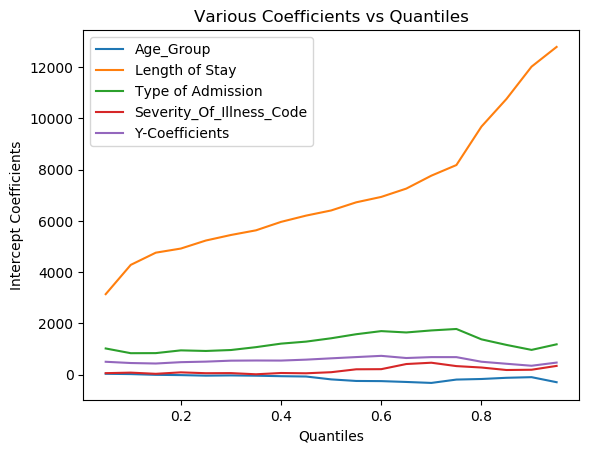

PyObject <matplotlib.legend.Legend object at 0x15990ebd0>

In [75]:
plot(Q, A[:, 1], label = "Age_Group")
plot(Q, A[:, 2], label = "Length of Stay")
plot(Q, A[:, 3], label = "Type of Admission")
plot(Q, A[:, 4], label = "Severity_Of_Illness_Code")



plot(Q, A[:, 22], label = "Y-Coefficients")



xlabel("Quantiles")
ylabel("Intercept Coefficients")
title("Various Coefficients vs Quantiles")
legend()

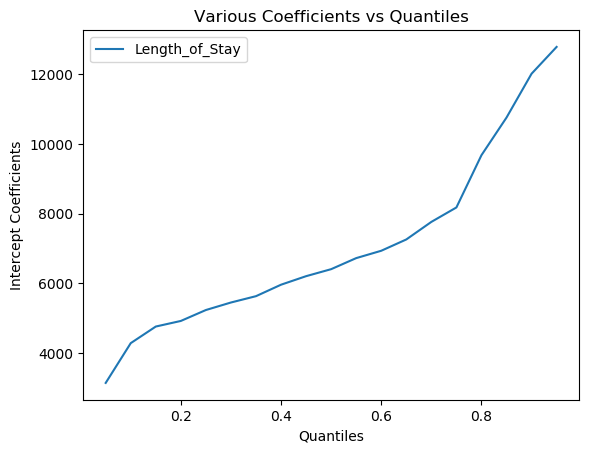

PyObject <matplotlib.legend.Legend object at 0x159c86150>

In [77]:
plot(Q, A[:, 2], label = "Length_of_Stay")


xlabel("Quantiles")
ylabel("Intercept Coefficients")
title("Various Coefficients vs Quantiles")
legend()

In [78]:
A[1, :]

22-element Array{Float64,1}:
    34.4577
  3140.27  
  1022.12  
    58.8353
   153.693 
   503.197 
   767.229 
 -3179.75  
  -344.066 
  3043.65  
  3471.74  
  -928.893 
     0.0   
 -1559.48  
   252.291 
   250.906 
   302.389 
   318.244 
    62.4263
     0.0   
     0.0   
   503.197 

In [ ]:
#************************************* Old Versions of Training & Test *************************************#
xTrain = head(BronxData, 1823)
yTrain = xTrain[:, :Total_Charges]
xTrain = delete!(xTrain, :Total_Charges)

xTrain = convert(Array, xTrain)
yTrain = convert(Array, yTrain)


fullDataTrain = [copy(xTrain[:, :]) yTrain]
#typeof(fullDataTrain)
fullDataTrain = fullDataTrain[shuffle(1:end), :]
fullDataTrain



labelList = Symbol[]
for i=1:20
    push!(labelList, names(xTrain)[i])
end
labelList


xTrain = convert(Array, xTrain)
xTrain = [copy(xTrain[:, :]) ones(length(xTrain[:,1]))]
yTrain = convert(Array, yTrain)

xTest = tail(BronxData, 2279 - 1823)
yTest = xTest[:, :Total_Charges]
xTest = delete!(xTest, :Total_Charges)

xTest = convert(Array, xTest)
xTest = [copy(xTest[:, :]) ones(length(xTest[:,1]))]
yTest = convert(Array, yTest)

w = xTrain\yTrain

In [47]:
5 ^ 2

25

In [48]:
sqrt(5^2)

5.0